In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt


In [2]:
filename = 'gnl_0002.blif.rent'
folder = '../benchmarks/rent_files'
rent_path = os.path.join(folder,filename)

In [3]:
with open(rent_path, "rb") as fp:   # Unpickling
    rent_data = pickle.load(fp)

In [4]:
rent_data
for level in rent_data:
    print(len(level))

1
2
4
8
16
32
64
128
256
512
1024
2048
4090
5088
1258
18


In [5]:
rent_data_flat = np.array([data_point for level in rent_data for data_point in level])

In [6]:
blocks = np.array(rent_data_flat)[:,0]
pins = np.array(rent_data_flat)[:,1]

### bin data

In [7]:
n_bins = 15

max_blocks = max(blocks)
max_blocks

11683

In [8]:
bin_factor = max_blocks**(1/(n_bins))
bin_values = []
bin_value = 1
for i in range(n_bins):
    bin_value*=bin_factor
    bin_values.append(bin_value)
bin_values[-1] += 1

In [9]:
#Sort on first column (blocks)
rent_data_flat = rent_data_flat[rent_data_flat[:,0].argsort()]

In [10]:
binned_data = []
sorted_mask = np.array([False]*len(rent_data_flat))
for bin_value in bin_values:
    bin_mask = rent_data_flat[:,0] <= bin_value
    bin_mask = bin_mask ^ sorted_mask
    binned_data.append(rent_data_flat[bin_mask])
    sorted_mask = sorted_mask | bin_mask
assert len(sorted_mask) == sorted_mask.sum()

In [55]:
bin_means = []
bin_stds = []
for data in binned_data:
    blocks_mean = data[:,0].mean()
    pins_mean = data[:,1].mean()
    bin_means.append([blocks_mean, pins_mean])
    bin_stds.append(data[:,1].std())
bin_means = np.array(bin_means)
bin_stds = np.array(bin_stds)

### Visualise data

array([  0.89029729,   1.54354855,   1.89628879,   2.51938773,
         3.3049162 ,   4.65899071,   6.52626823,   9.70578596,
        15.45229217,  21.96312566,  20.04328649,  45.74368126,
        54.29721448,  59.5       , 112.        ])

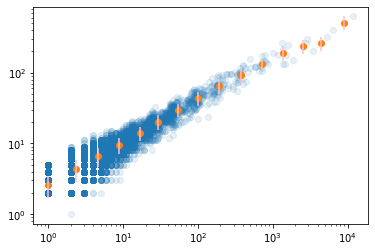

In [85]:
plt.xscale("log")
plt.yscale("log")
plt.scatter(blocks, pins, alpha = 0.1)
plt.scatter(bin_means[:,0], bin_means[:,1])

plt.vlines(bin_means[:,0], bin_means[:,1] - bin_stds, bin_means[:,1]+bin_stds, colors='pink')

bin_stds

### Find rent exponent

In [78]:
log_bin_means = np.log(bin_means)
#TODO: hoe stds weergeven op logaritmisch schaal (hierboven ook niet echt correct? )
log_bin_stds = np.log(bin_stds)
log_bin_stds

array([-0.11619984,  0.43408402,  0.63989871,  0.92401591,  1.19541112,
        1.53879884,  1.8758353 ,  2.2727222 ,  2.73775735,  3.08936494,
        2.99789426,  3.82305367,  3.99447293,  4.08597631,  4.71849887])

In [69]:
#TODO: geef gewicht aan bins .. op minder punten --> meer onzekerheid .. 
def trend_line(data):
    x = data[:,0]
    y = data[:,1]
    x_mean = x.mean()
    y_mean = y.mean()
    x_err = x-x_mean
    y_err = y-y_mean
    a = (x_err*y_err).sum()/ ((x_err)**2).sum()
    b = y_mean - x_mean*a
    first_point = [x[0], x[0]*a + b]
    last_point = [x[-1], x[-1]*a + b]
    
    #Error
    error = sum((y - (x*a + b))**2)/len(data)   
    
    return np.array([first_point, last_point]), a, b, error

In [70]:
trend_line(log_bin_means[:])

(array([[0.        , 1.04293582],
        [9.10475761, 6.25894471]]),
 0.5728882758704187,
 1.0429358181902901,
 0.010670769242976132)

In [71]:
int(n_bins/2)
n_selected_bins = 6
error_per_n_bins = [] ##Find the best error for sliding windows of selected number of bins
for n_selected_bins in range(int(3), n_bins+1):
    print(n_selected_bins)
    min_error = np.inf
    min_error_data = []
    for i in range(n_bins-n_selected_bins+1):
        line, slope, offset, error = trend_line(log_bin_means[i:i+n_selected_bins])
        if error < min_error:
            min_error = error
            min_error_data = log_bin_means[i:i+n_selected_bins]
    error_per_n_bins.append([n_selected_bins, min_error_data, min_error]) 
error_per_n_bins = np.array(error_per_n_bins, dtype=object)

3
4
5
6
7
8
9
10
11
12
13
14
15


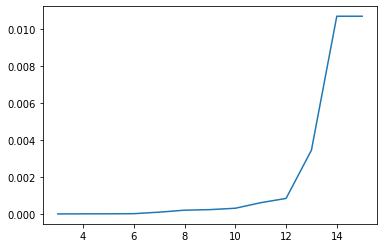

In [72]:
plt.plot(error_per_n_bins[:, 0], error_per_n_bins[:, -1])

In [73]:
error_per_n_bins[:, -1]

array([1.5472929524793767e-08, 3.660469701837697e-06,
       6.461086899936373e-06, 1.3173808974060997e-05,
       9.421322520901771e-05, 0.00020138541091773804,
       0.00023174017438376302, 0.0003059437494121016,
       0.0006055558292701609, 0.0008358830250058043,
       0.0034412237972068706, 0.01067070383820265, 0.010670769242976132],
      dtype=object)

In [74]:
##find best number of bins (to ommit rents first and second 'gebied' )
best_n_bins = 11 ## find this automatically ## find minimum and ... (? nog bedenken hoe juist)
selected_bins = error_per_n_bins[:,1][error_per_n_bins[:, 0] == best_n_bins][0]

trend_line(selected_bins)

(array([[0.        , 0.95528272],
        [6.56892025, 4.93989479]]),
 0.6065855441569915,
 0.9552827189770974,
 0.0006055558292701609)

bins: 6 	rent exponent: 0.63
bins: 7 	rent exponent: 0.62
bins: 8 	rent exponent: 0.61
bins: 9 	rent exponent: 0.62
bins: 10 	rent exponent: 0.61
bins: 11 	rent exponent: 0.61
bins: 12 	rent exponent: 0.60
bins: 13 	rent exponent: 0.59
bins: 14 	rent exponent: 0.57


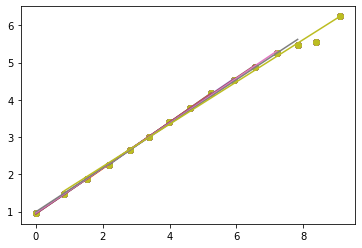

In [81]:
for selected_n_bins in range(6, 15):
    selected_bins = error_per_n_bins[:,1][error_per_n_bins[:, 0] == selected_n_bins][0]
    line, slope, offset, error = trend_line(selected_bins)
    print('bins:', selected_n_bins, '\trent exponent:', '{:.2f}'.format(slope))
    # plt.vlines(log_bin_means[:,0], log_bin_means[:,1]-log_bin_stds, log_bin_means[:,1]+log_bin_stds, colors='pink')
    plt.scatter(log_bin_means[:,0], log_bin_means[:,1])

    plt.plot(line[:,0], line[:,1])


In [21]:
print('Rent exponent:', slope)

Rent exponent: 0.5679829275678704
